<a href="https://colab.research.google.com/github/simonsavine/phasetype/blob/main/ann_normal_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

from scipy.special import gamma
import scipy.stats as scistats

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Normalization, BatchNormalization, Lambda, Reshape, Concatenate, Add
from tensorflow.keras.utils import PyDataset

import tensorflow_probability as tfp

from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm

from scipy.stats import norm

import time

1. Distribution, sampling, generation of dataset of params (ys) and samples (xs)

In [2]:
# useful definitions
par_names = ["mean", "stdev"]
par_size = len(par_names)

In [3]:
# dataset generation

def generate_parameters(num_examples):

  uniform = tf.linspace(np.float32(0), 1, num_examples+2)[1:-1]
  uniform = tf.random.shuffle(uniform)

  # mean = normal(0, 2)
  uniform_means = tf.random.shuffle(uniform)
  means = tfp.distributions.Normal(loc=0., scale=2.).quantile(uniform)

  # std = std = 0.01 + exp(0.8)
  uniform_stdevs = tf.random.shuffle(uniform)
  exponential_stdevs = 0.01 - tf.math.log(1.0 - uniform_stdevs) / .8
  parameters = tf.stack((means, exponential_stdevs), axis=-1)

  return tf.reshape(parameters, [num_examples, par_size]) # num_examples x par_size

def generate_samples(parameters, sample_size):

  num_examples = parameters.shape[0]
  means = parameters[:, 0]
  stdevs = parameters[:, 1]

  return tf.random.normal((num_examples, sample_size),
                        mean = tf.expand_dims(means, axis=-1),
                        stddev = tf.expand_dims(stdevs, axis=-1)
  )


# make sure average weight is 1, i.e. normalize all weights by the mean
# no weights --> return tf.ones([parameters.shape[0], 1])
def generate_weights(parameters, samples):
  return tf.ones([parameters.shape[0], 1])


def generate_dataset(num_examples, sample_size):
  parameters = generate_parameters(num_examples)
  samples = generate_samples(parameters, sample_size)
  weights = generate_weights(parameters, samples)

  return samples, parameters, weights

In [4]:
# activation for parameter prediction
def activate_predictions(predictions):
  return predictions

In [5]:
# test

(8, 2)
(8, 1024)


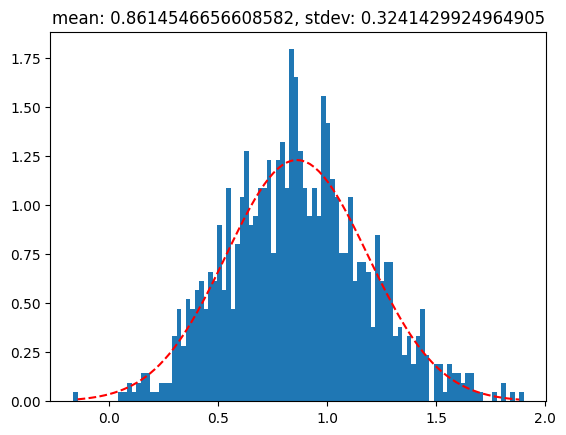

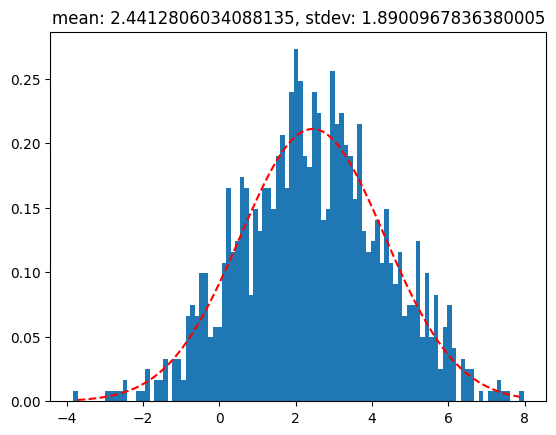

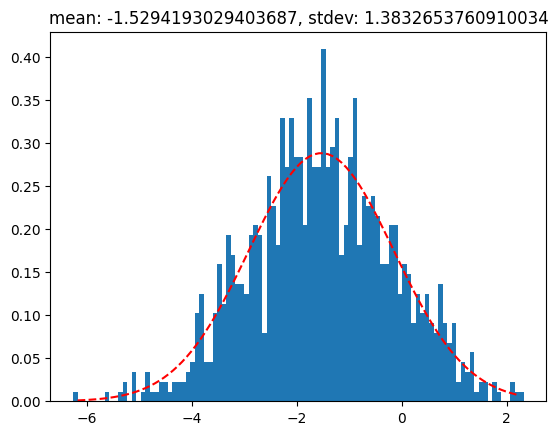

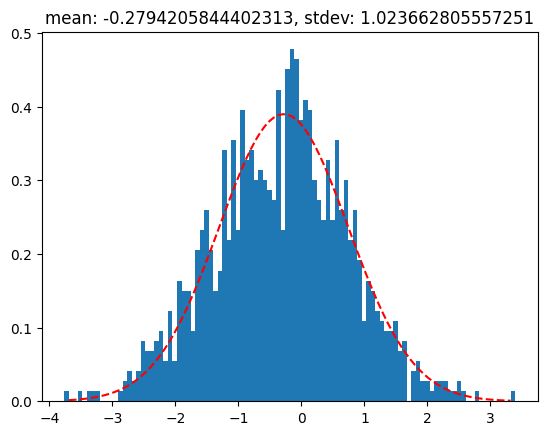

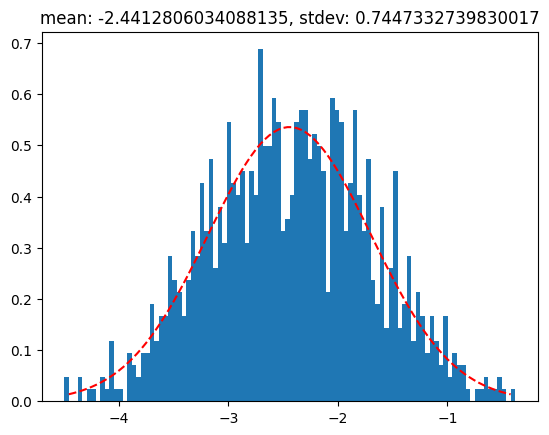

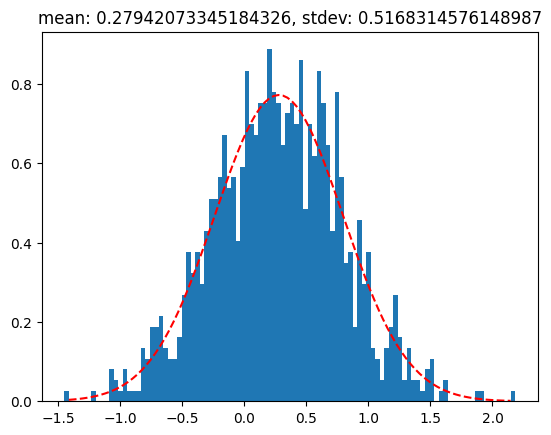

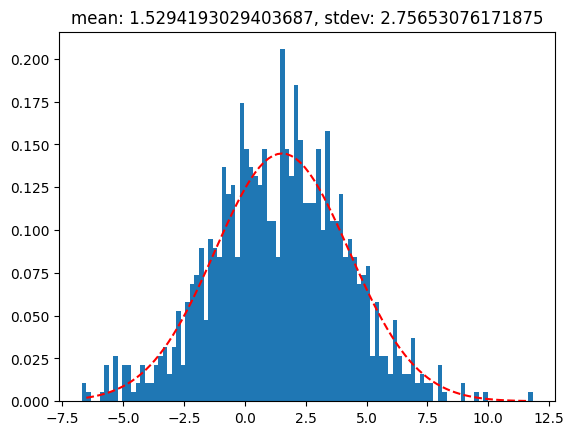

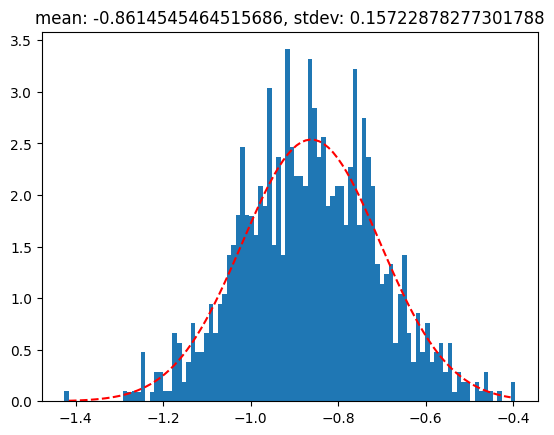

In [6]:
num_examples = 8
samples, params, weights = generate_dataset(num_examples, 1024)
print (params.shape)
print (samples.shape)
for i in range(num_examples):
  sample = samples[i]
  mean = params[i, 0]
  stdev = params[i, 1]
  xs = tf.linspace(np.min(sample), np.max(sample), 100)[1:-1]
  ys = scistats.norm.pdf(xs, loc=mean,  scale=stdev)
  plt.figure()
  plt.hist(sample, bins=100, density=True)
  plt.plot(xs, ys, 'r--')
  with np.printoptions(precision=2):
    plt.title(f"mean: {mean}, stdev: {stdev}")
  plt.show()

In [7]:
# can I correctly predict?

In [8]:
means = tf.constant([-2, 0, 2], dtype=tf.float32)
stdevs = tf.constant([1, 2, 3], dtype=tf.float32)
parameters = tf.stack([means, stdevs], axis=-1)
samples = generate_samples(parameters, 1024)
estimates = [tf.reduce_mean(samples, axis=-1), tf.math.reduce_std(samples, axis=-1)]

parameters, estimates

(<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-2.,  1.],
        [ 0.,  2.],
        [ 2.,  3.]], dtype=float32)>,
 [<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.9742084 , -0.08649481,  2.0088868 ], dtype=float32)>,
  <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.0092677, 2.0773084, 3.0191793], dtype=float32)>])

In [9]:
# do my weights average to 1?
_, _, weights = generate_dataset(4, 8)
mean = tf.reduce_mean(weights)
assert np.isclose(mean, 1)
weights

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

In [10]:
# end of tests -- all the code from here should be agnostic of distribution

In [11]:
# compute the (for now, unweighted) means and variances of inputs and outputs for normalization
def estimate_mean_var():
  xs, ys, ws = generate_dataset(131072, sample_size=1024)
  assert xs.shape == [131072, 1024]
  assert ys.shape == [131072, par_size]
  assert ws.shape == [131072, 1]
  assert np.isclose(tf.reduce_mean(ws), 1)
  mean_xs = tf.math.reduce_mean(xs)
  var_xs = tf.math.reduce_variance(xs)
  mean_ys = tf.math.reduce_mean(ys, axis=0)
  var_ys = tf.math.reduce_variance(ys, axis=0)
  assert mean_xs.shape == ()
  assert var_xs.shape == ()
  assert mean_ys.shape == (par_size)
  assert var_ys.shape == (par_size)

  nys = (ys - mean_ys) / tf.sqrt(var_ys)
  assert np.allclose(tf.reduce_mean(nys, axis=0), 0, atol=1e-6)
  assert np.allclose(tf.math.reduce_std(nys, axis=0), 1, atol=1e-6)

  return mean_xs, var_xs, mean_ys, var_ys

mean_xs, var_xs, mean_ys, var_ys = estimate_mean_var()
print(f"mean xs: {mean_xs:.2f}, var xs: {var_xs:.2f}")
with np.printoptions(precision=2):
  print(f"mean ys: {mean_ys}, var ys: {var_ys}")

mean xs: 0.00, var xs: 7.15
mean ys: [-1.30e-08  1.26e+00], var ys: [4.   1.56]


In [12]:
class DataGenerator(PyDataset):

    def __init__(
        self,
        epoch_size, # number of batches per epoch
        batch_size, # number of examples per batch
        num_samples, # number of samples per example
        sample_size, # sample size
        regenerate_every = 1, # a new dataset will be generated every regenerate_every epochs
        **kwargs):
      super().__init__(**kwargs)

      self.epoch_size = epoch_size
      self.batch_size = batch_size
      self.num_samples = num_samples
      self.sample_size = sample_size

      self.regenerate_every = regenerate_every

      self.rng = tf.range(self.epoch_size, dtype=tf.int32)
      self.epoch = 0

      self.on_epoch_end()

    def __len__(self):
      return self.epoch_size

    def __getitem__(self, batch_num):
      # xs: batch_size x num_samples x sample_size, ys: batch_size x 1 x par_size, weights: batch_size
      return self.xs[batch_num], self.ys[batch_num], self.weights[batch_num]

    def on_epoch_end(self):
      if self.epoch % self.regenerate_every == 0:
        # regenerate
        self.xs, self.ys, self.weights = generate_dataset(self.epoch_size * self.batch_size, self.num_samples * self.sample_size)
        self.par_size = self.ys.shape[-1]
        self.xs = tf.reshape(self.xs, [self.epoch_size, self.batch_size, self.num_samples * self.sample_size])
        self.xs = tf.reshape(self.xs, [self.epoch_size, self.batch_size, self.num_samples, self.sample_size])
        self.ys = tf.reshape(self.ys, [self.epoch_size, self.batch_size, 1, self.par_size])
        self.weights = tf.reshape(self.weights, [self.epoch_size, self.batch_size])
      else:
        # just shuffle
        r = tf.random.shuffle(self.rng)
        self.xs = tf.gather(self.xs, r)
        self.ys = tf.gather(self.ys, r)
        self.weights = tf.gather(self.weights, r)

      self.epoch += 1

In [13]:
# test shapes
gen = DataGenerator(4, 8, 16, 32)
assert len(gen) == 4
xs0, ys0, ws0 = gen[0]
assert xs0.shape == (8, 16, 32)
assert ys0.shape == (8, 1, par_size)
assert ws0.shape == (8)
xs, ys, ws = gen[0]
assert np.allclose(xs, xs0)
assert np.allclose(ys, ys0)
assert np.allclose(ws, ws0)
xs1, ys1, ws1 = gen[1]
assert xs1.shape == (8, 16, 32)
assert ys1.shape == (8, 1, par_size)
assert ws1.shape == (8)
assert not np.allclose(xs, xs1)
assert not np.allclose(ys, ys1)
gen.on_epoch_end()
xs0, ys0, ws0 = gen[0]
assert xs0.shape == (8, 16, 32)
assert ys0.shape == (8, 1, par_size)
assert not np.allclose(xs, xs0)
assert not np.allclose(ys, ys0)

2. Definition of the neural network

In [14]:
# network
embedding_size = 64
activation = "softplus"

def split_sample_into_observations(sample):
  return tf.expand_dims(sample, axis=-1)

def aggregate_embeddings(embeddings):
  # embeddings shape is [batch_size, num_samples, sample_size, embedding_size]
  # aggregation is across observations in the sample, hence axis -2
  means = tf.reduce_mean(embeddings, axis=-2)
  # [batch_size, num_samples, embedding_size]
  return means

embedding_network = Sequential([
    # input shape = [batch_size, num_samples, sample_size]
    # split subsamples into scalars
    Lambda(split_sample_into_observations), # [batch_size, nun_samples, sample_size, 1]
    # all embeddings go through embedding net
    # hidden layers
    Dense(embedding_size, activation=activation),
    Dense(embedding_size, activation=activation),
    # embedding layer, shape = [batch_size, num_samples, sample_size, embedding_size]
    Dense(embedding_size),
])

aggregation = Lambda(aggregate_embeddings)

prediction_network = Sequential([
    # input shape = [batch_size, num_samples, embedding_size]
    # hidden layers
    Dense(embedding_size, activation=activation),
    Dense(embedding_size, activation=activation),
    Dense(embedding_size, activation=activation),
    # output layer, shape [batch_size, num_samples, par_size]
    Dense(par_size),
    Lambda(activate_predictions),
])

model = Sequential([
    # input shape = [(batch_size), num_samples, sample_size]
    Input([None, None]),
    # normalization by mean and standard dev of xs
    Normalization(axis=None, mean=mean_xs, variance=var_xs),
    # deep set
    embedding_network, # [(batch_size), num_samples, sample_size, embedding_size]
    aggregation, # [(batch_size), num_samples, embedding_size]
    prediction_network, # [(batch_size), num_samples, par_size]
])

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, None, None)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, None, None, 64)      │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, None, 2)             │          12,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,058 (82.26 KB)

 Trainable params: 21,058 (82.26 KB)

 Non-trainable params: 0 (0.00 B)

3. Training loop

In [16]:
# custom loss = alpha * bias^2 + (1 - alpha) * variance, weighted by standard dev of parameters
normalise_by_stdev = True
stdevs = tf.constant(tf.sqrt(var_ys), dtype=tf.float32)
assert stdevs.shape == [par_size]

alpha = 0.99
alpha = tf.constant(alpha, dtype=tf.float32)
beta = tf.constant(1. - alpha, dtype=tf.float32)

# sample weights are included by tensorflow
def loss(y_true, y_pred):
  # y_true: [batch_size, 1, par_size]
  # y_pred: [batch_size, num_samples, par_size]
  # errors: [batch_size, num_samples, par_size]
  errors = y_pred - y_true # [batch_size, num_samples, par_size]
  # weight by stdev
  if normalise_by_stdev:
    errors /= tf.reshape(stdevs, (1,)*(errors.ndim-1) + (-1,))
  # still [batch_size, num_samples, par_size]
  # bias and variance, reduced on samples and parameters
  bias = tf.reduce_mean(errors, axis=-2) # [batch_size, par_size]
  bias2 = tf.square(bias) # [batch_size, par_size]
  variance = tf.math.reduce_variance(errors, axis=-2) # [batch_size, par_size]
  # and aggregate, not 'mse' is mse only if alpha = 0.5
  mse = alpha * bias2 + beta * variance # [batch_size, par_size]
  # now average among parameters
  return tf.reduce_mean(mse, axis=-1)


In [17]:
# training
regenerate_every = 1

batch_size = 256
epoch_size = 32
num_samples = 128
sample_size = 256

val_batch_size = 128
val_num_samples = 64
val_sample_size = 1024

In [18]:
# data generators
train_data = DataGenerator(epoch_size, batch_size, num_samples, sample_size, regenerate_every=regenerate_every)
# so we verify performance on differently sized samples every epoch
val_data = DataGenerator(1, val_batch_size, val_num_samples, val_sample_size, regenerate_every=regenerate_every)

In [19]:
# callbacks
def callbacks():
  cb1 = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",
                                             factor=0.75,
                                             patience=10,
                                             )
  cb2 = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=50,
                                         restore_best_weights=True)
  cb3 = TqdmCallback(verbose=1)
  return [cb1, cb2, cb3]

In [20]:
# training loop
optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-2)
model.compile(optimizer=optimizer, loss=loss)

In [ ]:
epochs = 500
model.fit(train_data, epochs=epochs, verbose=0, callbacks=callbacks(), validation_data=val_data)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# evaluate on different sample sizes
sz = 1024
val_data = DataGenerator(1, val_batch_size, val_num_samples, sz)
model.evaluate(val_data)

In [ ]:
# save trained model
model.save("/content/drive/MyDrive/neural_estimators/norm_final.keras")

In [21]:
# load trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/neural_estimators/norm_final.keras', safe_mode=False,
                                   custom_objects={"custom_loss": loss,
                                                   "split_sample_into_observations": split_sample_into_observations,
                                                   "aggregate_embeddings": aggregate_embeddings,
                                                   "activate_predictions": activate_predictions})


4. Evaluation

In [22]:
# estimation
# network is fixed, we use it to makes estimates

In [23]:
mle_avail = True

# only for reference, doesn't use network
# samples shape = [batch_size, sample_size]
# output shape = [batch_size, par_size]
def estimate_mle(samples):
  return tf.stack([tf.reduce_mean(samples, axis=-1), tf.math.reduce_std(samples, axis=-1)], axis=-1)

In [24]:
# estimate with neural net

# input: samples, shape = [batch_size, sample_size]
# outputs: predictions, shape = [batch_size, par_size]
def estimate_ann(model, samples):
  predictions = model.predict(tf.reshape(samples, [samples.shape[0], 1, samples.shape[-1]]), verbose=False)
  return tf.reshape(predictions, [-1, par_size])

In [25]:
def evaluate(model, configs, num_experiments=64, sample_size=1024,
             with_mle = False):

  configs = np.array(configs, dtype=np.float32)
  config_size, nparams = configs.shape
  assert nparams == par_size

  # samples
  samples = generate_samples(configs, num_experiments * sample_size)
  samples = tf.reshape(samples, [config_size, num_experiments, sample_size])
  #

  # predictions
  reshaped_samples = tf.reshape(samples, [-1, sample_size])
  assert reshaped_samples.shape == [config_size * num_experiments, sample_size]

  ann_estimates = estimate_ann(model, reshaped_samples)
  assert ann_estimates.shape == (config_size * num_experiments, par_size), f"{ann_estimates.shape}"
  ann_estimates = tf.reshape(ann_estimates, [config_size, num_experiments, par_size])

  if with_mle:
      mle_estimates = estimate_mle(reshaped_samples)
      assert list(mle_estimates.shape) == [config_size * num_experiments, par_size], f"{mle_estimates.shape}"
      mle_estimates = tf.reshape(mle_estimates, [config_size, num_experiments, par_size])

  # graphs
  xaxis = tf.range(num_experiments)

  ratios = np.zeros(par_size * 2, dtype = int)
  for i in range(par_size):
    ratios[2 * i] = 5
    ratios[2 * i + 1] = 2

  fig, axs = plt.subplots(config_size, par_size * 2, figsize=(5 * par_size, 4*len(configs)),
                          gridspec_kw={
              "width_ratios" : ratios
        })

  for i in range(config_size):
    for j in range(par_size):
      config = configs[i, j]
      if with_mle:
        mles = mle_estimates[i, :, j]
      nests = ann_estimates[i, :, j]
      rmse = np.sqrt(np.mean((nests - config)**2))
      bias = np.mean(nests) - config
      std = np.std(nests)

      # curve
      ax = axs[i, 2 * j]
      if with_mle:
        ax.plot(xaxis, mles, 'g-', label="mle" )
      ax.plot(xaxis, nests, 'r--', label="ann" )
      ax.plot(xaxis, np.ones_like(xaxis) * config, 'b-', label="true" )
      ax.set_xlabel(f"{num_experiments} experiments")
      ax.set_title(f"{par_names[j]} ={config:.2f}, rmse={rmse:.3f}, bias={bias:.3f}, stdev={std:.3f}", fontsize=10)

      # histogram
      ax = axs[i, 2* j + 1]

      ax.hist(nests, bins = num_experiments // 5, density=True, color='orange', edgecolor='red', alpha=.5, linewidth=1)

      # mess
      if False: # with_mle:
        ax.hist(mles, bins = num_experiments // 5, density=True, color='yellow', edgecolor='green', alpha=.5, linewidth=1)

      ax.set_xlabel("predictions")
      ax.set_ylabel("density")
      xmin = np.min(nests)
      xmax = np.max(nests)
      xmean = np.mean(nests)
      xstd = np.std(nests)

      ax.set_xticks([xmin, xmean-xstd, xmean, xmean+xstd, xmax])
      ax.tick_params(axis='x', labelrotation=90, labelsize=8)
      ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      ax.set_yticks([])

      xs = np.linspace(xmin, xmax, 256)
      ys = norm.pdf(xs, xmean, xstd)
      ax.plot(xs, ys, 'r--')
      ax.axvline(x=config, color='b')

      # mess
      if False: # with_mle:
        ys = norm.pdf(xs, np.mean(mles), np.std(mles))
        ax.plot(xs, ys, 'b--')

  handles, labels = axs[0, 0].get_legend_handles_labels()
  fig.legend(handles, labels, loc="lower center")
  fig.suptitle(f"ANN evaluation with sample size {sample_size}")
  plt.tight_layout(rect=[0, 0.05, 1, 0.98])

In [32]:
configs = [
    [-2., 0.5],
    [0., 2.],
    [1., 1.],
    [5., 5.]
]

configs = np.array(configs)

configs.shape

(4, 2)

In [33]:
# do graphs with or without MLE
with_mle = True

# always False when not available
with_mle = with_mle if mle_avail else False

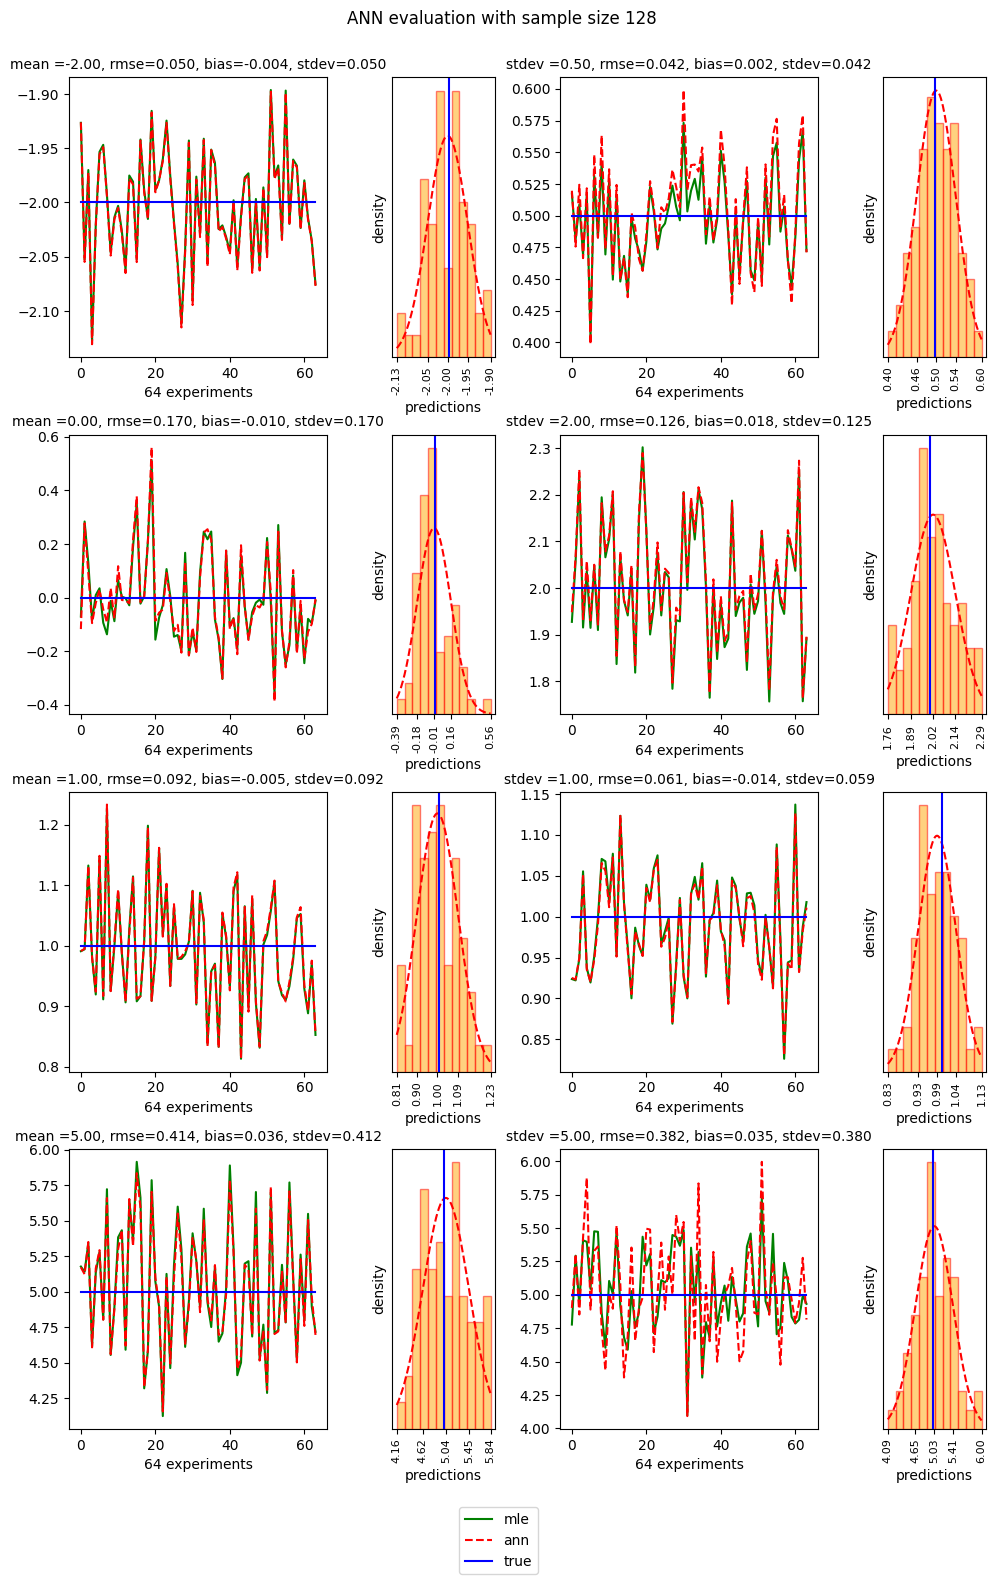

In [34]:
# small sample size
evaluate(model, configs, sample_size=128, with_mle=with_mle)

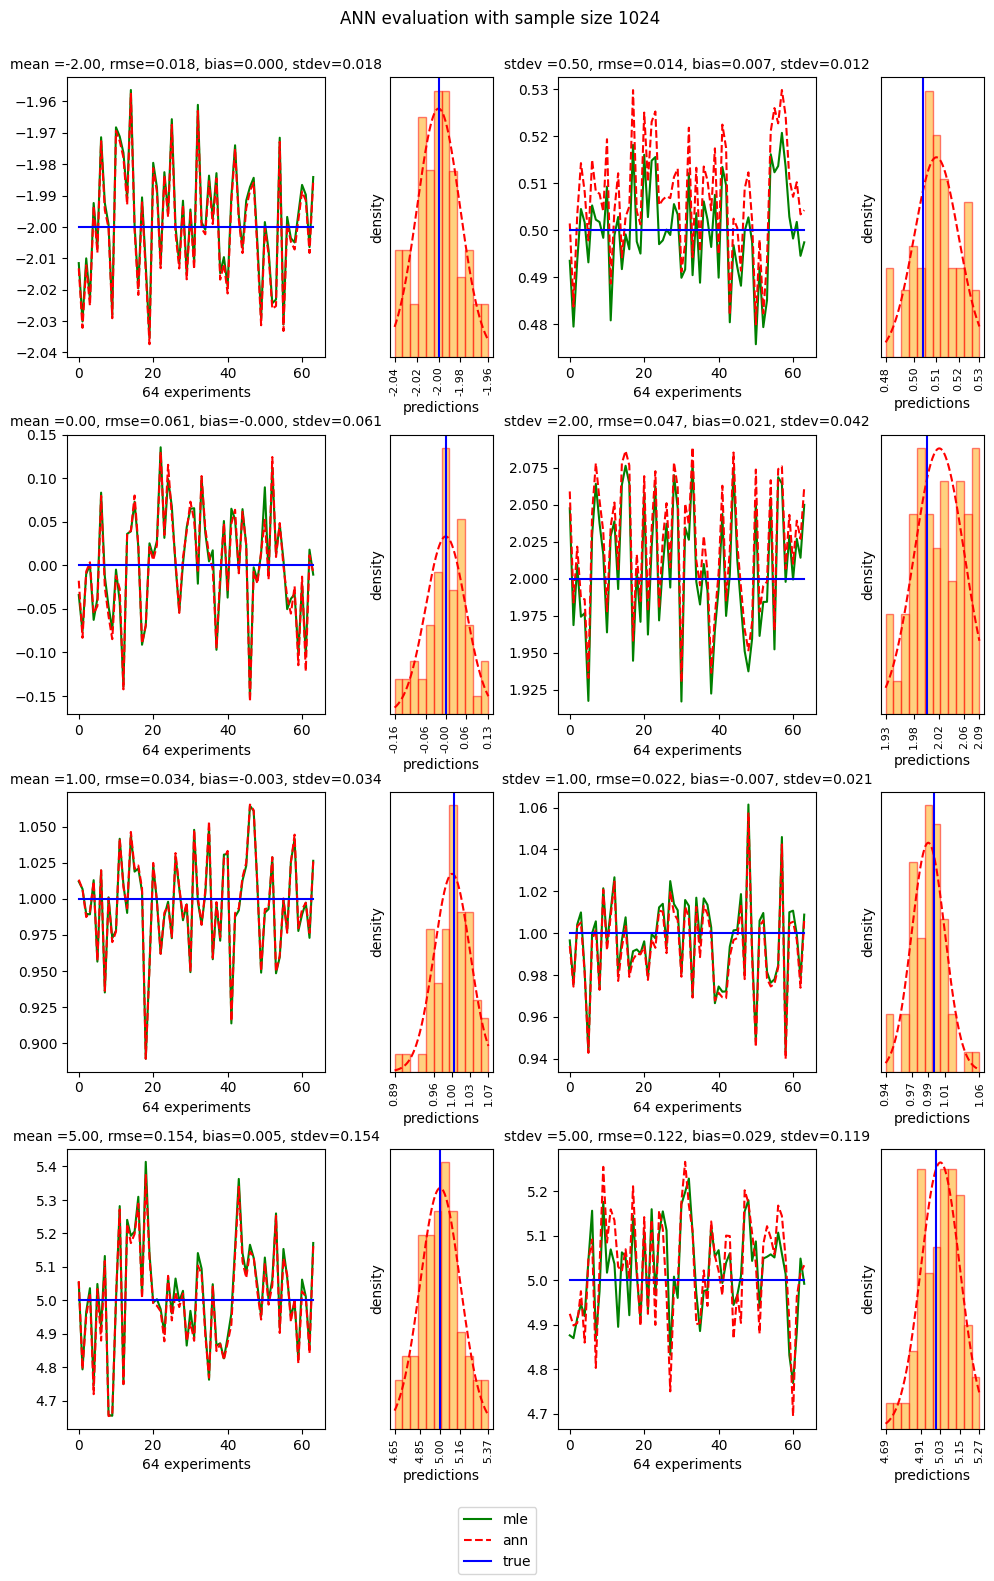

In [35]:
# medium sample size
evaluate(model, configs, sample_size = 1024, with_mle=with_mle)

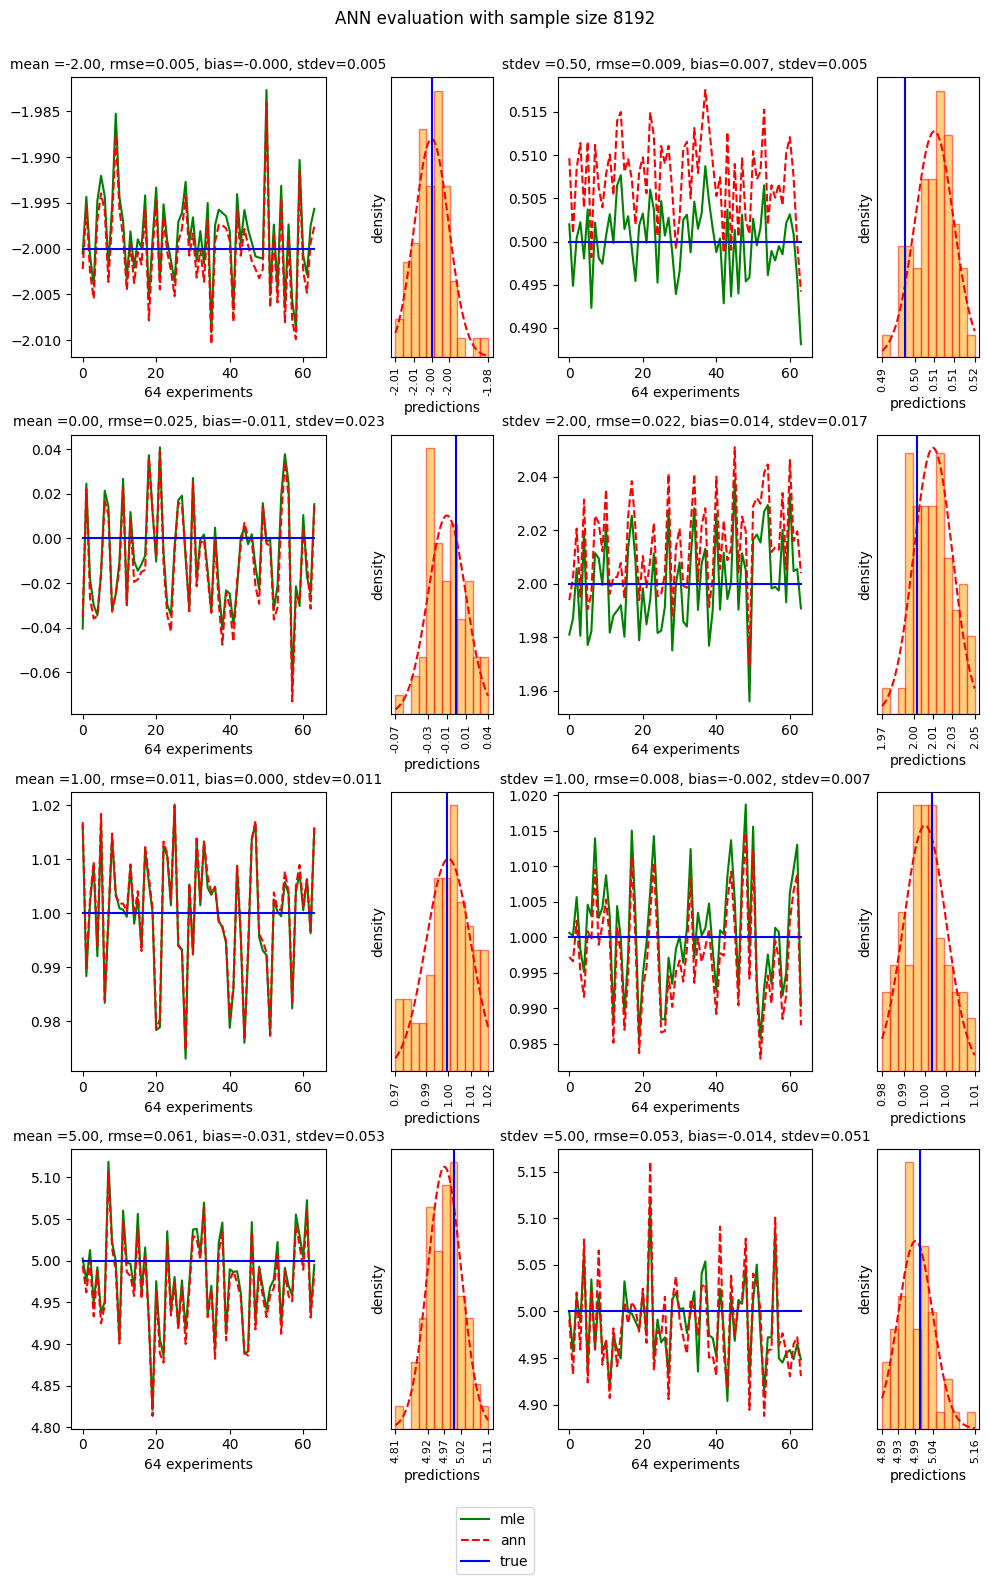

In [36]:
# large sample size
evaluate(model, configs, sample_size = 8192, with_mle=with_mle)

  0%|          | 0/32 [00:00<?, ?it/s]

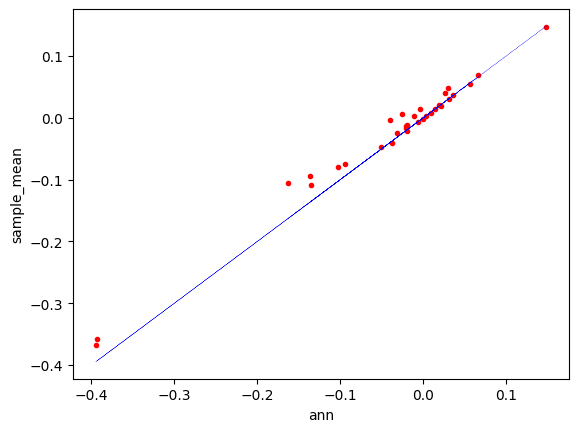

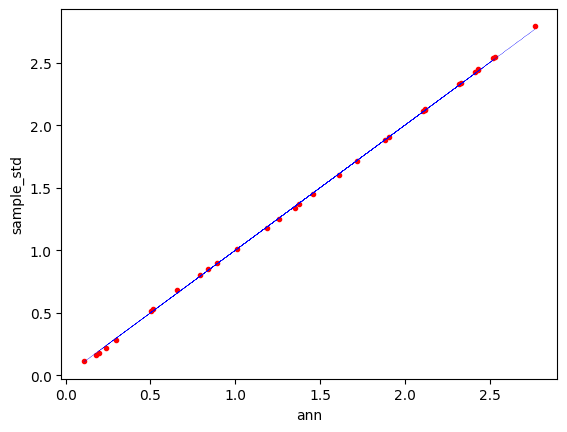

In [38]:
means = []
stds = []
pred_means = []
pred_stds = []

for _ in tqdm(range(32)):
  # pick size
  n = np.random.choice(1024) + 32
  # pick bounds
  p = np.random.uniform(0.1, 5.)
  # draw uniform
  x = np.random.uniform(-p, p, size=n)
  means.append(x.mean())
  stds.append(x.std())
  preds =  tf.squeeze(model.predict(tf.reshape(x, [1, 1, n]), verbose=False))
  pred_means.append(preds[0])
  pred_stds.append(preds[1])

plt.figure()
plt.plot(means, pred_means, "r.")
plt.plot(means, means, "b--", linewidth=0.2)
plt.xlabel("ann")
plt.ylabel("sample_mean")
plt.show()

plt.figure()
plt.plot(stds, pred_stds, "r.")
plt.plot(stds, stds, "b--", linewidth=0.2)
plt.xlabel("ann")
plt.ylabel("sample_std")
plt.show()